[WARN] SEC_USER_AGENT is not set. Using a placeholder User-Agent.
       Please set it before running, e.g.:
       export SEC_USER_AGENT="Your Name (your.email@example.com) - research"

PROJECT_ROOT: /Users/Hanjing1/JupyterProjects/biopharm-10k-ai-digital-disclosure-analysis/notebooks
PROCESSED_DIR: /Users/Hanjing1/JupyterProjects/biopharm-10k-ai-digital-disclosure-analysis/notebooks/data/processed
FIG_DIR: /Users/Hanjing1/JupyterProjects/biopharm-10k-ai-digital-disclosure-analysis/notebooks/figures
CACHE_DIR: /Users/Hanjing1/JupyterProjects/biopharm-10k-ai-digital-disclosure-analysis/notebooks/data/cache_sec/moderna

Keyword set (small + stable):
 - artificial intelligence
 - machine learning
 - deep learning
 - generative ai
 - advanced analytics
 - data platform
 - real-world evidence
 - real-world data
 - predictive
 - digital transformation
 - automation
 - decision support
 - ai token (AI / A.I. / A. I.) — strict standalone only

10-K filings selected for FY2020–FY2024: 5
     f

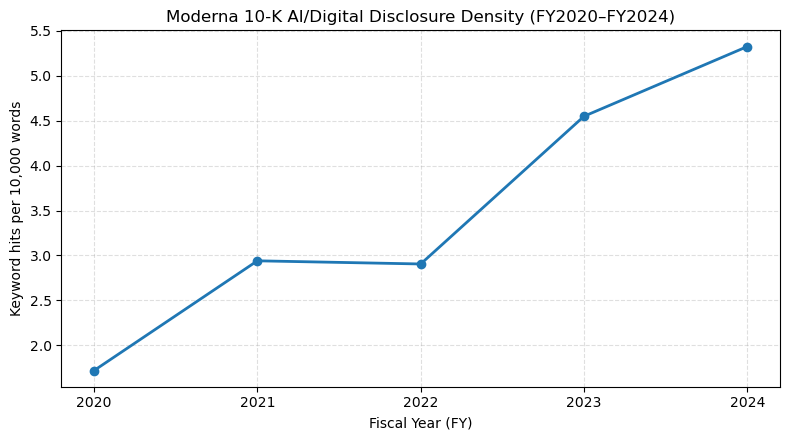

Saved figure: /Users/Hanjing1/JupyterProjects/biopharm-10k-ai-digital-disclosure-analysis/notebooks/figures/moderna_density_FY2020_FY2024.png


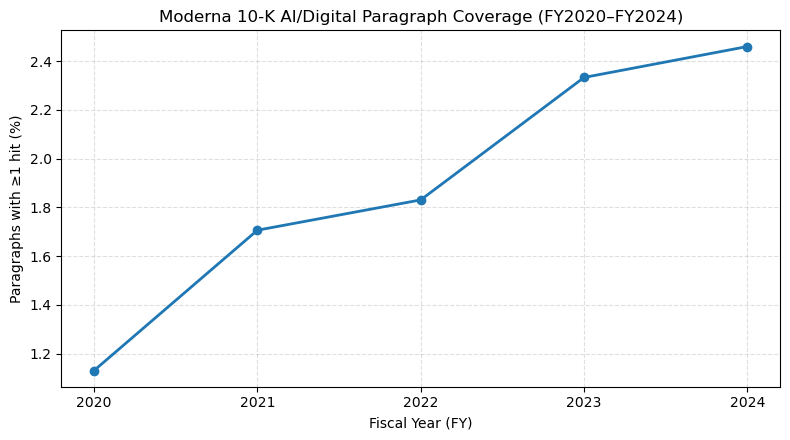

Saved figure: /Users/Hanjing1/JupyterProjects/biopharm-10k-ai-digital-disclosure-analysis/notebooks/figures/moderna_para_coverage_FY2020_FY2024.png

Result table (key columns):
  FY  word_count  hit_count  density_per_10k  para_count  para_hits  para_hit_share       chosen_html
2020      174503         30         1.719168        1681         19        0.011303 mrna-20201231.htm
2021      112230         33         2.940390        1055         18        0.017062 mrna-20211231.htm
2022      110147         32         2.905208        1038         19        0.018304 mrna-20221231.htm
2023      101115         46         4.549276         943         22        0.023330 mrna-20231231.htm
2024       99519         53         5.325616         935         23        0.024599 mrna-20241231.htm

Keyword breakdown (non-zero only):
  FY                 keyword  raw_hits
2020              automation        12
2020            __AI_TOKEN__         6
2020              predictive         5
2020 artificial int

In [1]:
# ============================================================
# Module 04 — Moderna 10-K AI/Digital Disclosure (FY2020–FY2024)
# - Fetch 10-K HTML from SEC EDGAR (polite: User-Agent + rate limit)
# - Count keyword hits (unique span counting to avoid double-counting overlaps)
# - Compute:
#     (1) keyword density (hits per 10,000 words)  [FULL TEXT]
#     (2) paragraph coverage (% paragraphs with >=1 hit) [FINER PARAGRAPHS]
# - Save outputs to:
#     data/processed/*.csv
#     figures/*.png
# - Extra audit output:
#     data/processed/*_keyword_breakdown_*.csv  (per-FY per-keyword raw hits)
# ============================================================

import os
import re
import json
import time
from pathlib import Path

import requests
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 0) Config
# -----------------------------
CIK = "0001682852"  # Moderna
COMPANY_NAME = "Moderna"
COMPANY_SLUG = "moderna"  # used only for cache/output filenames
FY_START, FY_END = 2020, 2024

# SEC requests MUST include a descriptive User-Agent with contact info.
# GitHub-safe (scheme 2): read from env; if missing, warn and use a placeholder.
# Example (macOS/Linux):
#   export SEC_USER_AGENT="Your Name (your_email@domain.com) - academic research"
# Example (Windows PowerShell):
#   setx SEC_USER_AGENT "Your Name (your_email@domain.com) - academic research"
USER_AGENT = os.getenv("SEC_USER_AGENT")
if not USER_AGENT or not USER_AGENT.strip():
    print(
        "[WARN] SEC_USER_AGENT is not set. Using a placeholder User-Agent.\n"
        "       Please set it before running, e.g.:\n"
        '       export SEC_USER_AGENT="Your Name (your.email@example.com) - research"\n'
    )
    USER_AGENT = "Your Name (your.email@example.com) - research"

HEADERS = {
    "User-Agent": USER_AGENT.strip(),
    "Accept-Encoding": "gzip, deflate",
    "Accept": "application/json,text/html,*/*",
    "Connection": "keep-alive",
}

# Be conservative on rate limiting (SEC guidance: keep request rate low)
SLEEP_S = 0.25  # ~4 requests/sec max

# -----------------------------
# 1) Project root + folders
# -----------------------------
def find_project_root(start_path: str) -> Path:
    """
    Try to locate a sensible project root.
    If you run the notebook inside /notebooks, this will go up to the repo root.
    """
    p = Path(start_path).resolve()
    for cand in [p] + list(p.parents):
        if (cand / "data").exists() or (cand / "figures").exists() or (cand / "notebooks").exists():
            return cand
    return p

PROJECT_ROOT = find_project_root(os.getcwd())
DATA_DIR = PROJECT_ROOT / "data"
PROCESSED_DIR = DATA_DIR / "processed"
FIG_DIR = PROJECT_ROOT / "figures"

# Company-specific cache folder (avoid collisions across companies)
CACHE_DIR = DATA_DIR / "cache_sec" / COMPANY_SLUG

for d in [PROCESSED_DIR, FIG_DIR, CACHE_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("PROJECT_ROOT:", str(PROJECT_ROOT))
print("PROCESSED_DIR:", str(PROCESSED_DIR))
print("FIG_DIR:", str(FIG_DIR))
print("CACHE_DIR:", str(CACHE_DIR))

# -----------------------------
# 2) Keyword patterns (small + stable) + rule-based AI token
# -----------------------------
PHRASE_KEYWORDS = [
    "artificial intelligence",
    "machine learning",
    "deep learning",
    "generative ai",
    "advanced analytics",
    "data platform",
    "real-world evidence",
    "real-world data",
    "predictive",
    "digital transformation",
    "automation",
    "decision support",
]

INCLUDE_AI_TOKEN = True  # match AI / A.I. / A. I. as a standalone token only

def compile_keyword_patterns(phrases, include_ai_token=True):
    """
    Compile named regex patterns for keyword matching.

    Why "named"?
    - So we can audit which exact keyword triggered hits (e.g., AI token vs. "artificial intelligence").

    Matching rules:
    - Phrase keywords: whole-phrase matching (case-insensitive, flexible whitespace).
    - AI token: matches "AI" / "A.I." / "A. I." as a standalone token only.
      It will NOT match inside words or within larger tokens like 'OpenAI' or 'GenAI'.

    Note on case:
    - All patterns use re.IGNORECASE, so matching is NOT affected by capitalization.
    """
    named_patterns = []

    for kw in phrases:
        kw_pat = re.escape(kw).replace(r"\ ", r"\s+")
        named_patterns.append((kw, re.compile(rf"\b{kw_pat}\b", re.IGNORECASE)))

    if include_ai_token:
        named_patterns.append(("__AI_TOKEN__", re.compile(r"(?<!\w)a\.?\s*i\.?(?!\w)", re.IGNORECASE)))

    return named_patterns

KEYWORD_PATTERNS = compile_keyword_patterns(PHRASE_KEYWORDS, include_ai_token=INCLUDE_AI_TOKEN)

print("\nKeyword set (small + stable):")
for kw in PHRASE_KEYWORDS:
    print(" -", kw)
if INCLUDE_AI_TOKEN:
    print(" - ai token (AI / A.I. / A. I.) — strict standalone only")

# -----------------------------
# 3) Polite SEC fetch with caching + retry
# -----------------------------
session = requests.Session()

def sec_get(url, sleep_s=SLEEP_S, cache_path=None, timeout=30, max_retries=3):
    """
    Polite SEC fetch:
    - Adds required User-Agent header
    - Rate limits
    - Caches responses when cache_path is provided
    - Retries on transient failures (403/429/5xx)
    """
    if cache_path and Path(cache_path).exists():
        with open(cache_path, "rb") as f:
            return f.read(), True

    last_err = None
    for attempt in range(1, max_retries + 1):
        try:
            r = session.get(url, headers=HEADERS, timeout=timeout)

            if r.status_code in (403, 429, 500, 502, 503, 504):
                time.sleep(sleep_s * attempt)
                last_err = Exception(f"HTTP {r.status_code} for {url}")
                continue

            r.raise_for_status()
            content = r.content

            if cache_path:
                Path(cache_path).parent.mkdir(parents=True, exist_ok=True)
                with open(cache_path, "wb") as f:
                    f.write(content)

            time.sleep(sleep_s)
            return content, False

        except Exception as e:
            last_err = e
            time.sleep(sleep_s * attempt)

    raise last_err

def get_submissions_json(cik_str):
    cik_int = int(cik_str)
    url = f"https://data.sec.gov/submissions/CIK{cik_int:010d}.json"
    cache_path = CACHE_DIR / f"submissions_CIK{cik_int:010d}.json"
    raw, cached = sec_get(url, cache_path=str(cache_path))
    return json.loads(raw.decode("utf-8")), cached

def get_filing_index_json(cik_str, accession):
    cik_int = int(cik_str)
    acc_nodash = accession.replace("-", "")
    url = f"https://www.sec.gov/Archives/edgar/data/{cik_int}/{acc_nodash}/index.json"
    cache_path = CACHE_DIR / f"index_{cik_int}_{acc_nodash}.json"
    raw, cached = sec_get(url, cache_path=str(cache_path))
    return json.loads(raw.decode("utf-8")), cached, url

# -----------------------------
# 4) Select 10-K for FY2020–FY2024
# -----------------------------
def extract_10k_table(submissions):
    recent = submissions.get("filings", {}).get("recent", {})
    if not recent:
        return pd.DataFrame()

    df = pd.DataFrame(recent)

    # Keep only 10-K
    df = df[df["form"].astype(str).str.upper().eq("10-K")].copy()

    needed = ["form", "filingDate", "reportDate", "accessionNumber", "primaryDocument"]
    for c in needed:
        if c not in df.columns:
            df[c] = None

    df["FY"] = pd.to_datetime(df["reportDate"], errors="coerce").dt.year
    df["filingDate_dt"] = pd.to_datetime(df["filingDate"], errors="coerce")

    df = df.sort_values("filingDate_dt").dropna(subset=["FY"])

    # One filing per FY: keep the latest filingDate
    df = df.groupby("FY", as_index=False).tail(1)

    return df[["form", "filingDate", "reportDate", "accessionNumber", "primaryDocument", "FY"]].sort_values("FY")

subs, cached_sub = get_submissions_json(CIK)
df_10k_all = extract_10k_table(subs)

df_10k = df_10k_all[(df_10k_all["FY"] >= FY_START) & (df_10k_all["FY"] <= FY_END)].copy()
print(f"\n10-K filings selected for FY{FY_START}–FY{FY_END}: {len(df_10k)}")
print(df_10k)

if df_10k.empty:
    raise RuntimeError("No 10-K filings found in submissions.recent for the requested FY range.")

# -----------------------------
# 5) Fetch filing HTML (robust selection)
# -----------------------------
def build_primary_doc_url(cik_str, accession, primary_doc):
    cik_int = int(cik_str)
    acc_nodash = accession.replace("-", "")
    return f"https://www.sec.gov/Archives/edgar/data/{cik_int}/{acc_nodash}/{primary_doc}"

def choose_html_from_index(index_json, fallback_primary=None):
    """
    Choose a likely HTML document from filing index.json if primaryDocument 404s.
    """
    items = index_json.get("directory", {}).get("item", [])
    htmls = [
        it["name"] for it in items
        if isinstance(it.get("name"), str) and it["name"].lower().endswith((".htm", ".html"))
    ]

    if fallback_primary and fallback_primary in htmls:
        return fallback_primary

    htmls = [h for h in htmls if "index" not in h.lower()]

    scored = []
    for h in htmls:
        hn = h.lower()
        score = 0
        if "10k" in hn or "10-k" in hn:
            score += 3
        if "form" in hn:
            score += 2
        scored.append((score, h))
    scored.sort(reverse=True)

    return scored[0][1] if scored else None

def fetch_10k_html(cik_str, accession, primary_doc):
    """
    Try primaryDocument first; if it 404s, use index.json to pick an alternate HTML file.
    Returns (url, html_text, chosen_html_name).
    """
    url_primary = build_primary_doc_url(cik_str, accession, primary_doc)
    cache_path = CACHE_DIR / f"html_{int(cik_str)}_{accession.replace('-', '')}_{primary_doc}"
    try:
        raw, _ = sec_get(url_primary, cache_path=str(cache_path))
        return url_primary, raw.decode("utf-8", errors="ignore"), primary_doc
    except Exception:
        pass

    idx_json, _, idx_url = get_filing_index_json(cik_str, accession)
    chosen = choose_html_from_index(idx_json, fallback_primary=primary_doc)
    if not chosen:
        raise RuntimeError(f"Could not find an HTML document in filing index: {idx_url}")

    url_alt = build_primary_doc_url(cik_str, accession, chosen)
    cache_path2 = CACHE_DIR / f"html_{int(cik_str)}_{accession.replace('-', '')}_{chosen}"
    raw2, _ = sec_get(url_alt, cache_path=str(cache_path2))
    return url_alt, raw2.decode("utf-8", errors="ignore"), chosen

# -----------------------------
# 6) HTML -> text -> paragraphs (no extra dependencies)
# -----------------------------
def html_to_text(html):
    html = re.sub(r"(?is)<(script|style).*?>.*?(</\1>)", " ", html)
    html = re.sub(r"(?i)<br\s*/?>", "\n", html)
    html = re.sub(r"(?i)</p\s*>", "\n\n", html)
    text = re.sub(r"(?s)<.*?>", " ", html)
    text = re.sub(r"[ \t\r\f\v]+", " ", text)
    text = re.sub(r"\n{3,}", "\n\n", text)
    return text.strip()

def _normalize_for_paragraphs(text: str) -> str:
    """Normalize text for stable paragraph splitting (does NOT change density inputs)."""
    text = text.replace("\r\n", "\n").replace("\r", "\n")
    text = re.sub(r"[ \t]+", " ", text)
    text = re.sub(r"\n{3,}", "\n\n", text)
    return text.strip()

def word_count(text):
    return len(re.findall(r"\b\w+\b", text))

def text_to_paragraphs(text, min_words=25, max_words=120):
    """
    Produce finer and more stable paragraphs for coverage calculation.

    Strategy:
    1) Split by blank lines -> coarse blocks
    2) Further split blocks by bullet/numbered list lines
    3) If a block is very long, split into sentence-like pieces and pack into ~max_words chunks
    4) Merge extremely short pieces into the previous paragraph to avoid noisy para_count inflation
    """
    t = _normalize_for_paragraphs(text)

    # 1) Coarse split by blank lines
    blocks = [b.strip() for b in re.split(r"\n\s*\n+", t) if b.strip()]

    pieces = []
    for blk in blocks:
        # 2) Split by bullet / numbered list starters
        sub_blocks = re.split(r"\n(?=\s*(?:[-*•]|\d+[\.\)])\s+)", blk)

        for sb in sub_blocks:
            sb = sb.strip()
            if not sb:
                continue

            # 3) If too long, split by sentence-ish boundaries and then pack
            if word_count(sb) > max_words:
                sents = re.split(r"(?<=[\.\?!])\s+(?=[A-Z0-9])", sb)

                tmp = []
                for s in sents:
                    tmp.extend(re.split(r"(?<=;)\s+(?=[A-Z0-9])", s))
                sents = [x.strip() for x in tmp if x.strip()]

                buf = []
                for s in sents:
                    if not buf:
                        buf = [s]
                        continue
                    candidate = " ".join(buf + [s])
                    if word_count(candidate) <= max_words:
                        buf.append(s)
                    else:
                        pieces.append(" ".join(buf).strip())
                        buf = [s]
                if buf:
                    pieces.append(" ".join(buf).strip())
            else:
                pieces.append(sb)

    # 4) Merge short pieces
    merged = []
    for p in pieces:
        if not merged:
            merged.append(p)
            continue
        if word_count(p) < min_words:
            merged[-1] = (merged[-1].rstrip() + " " + p.lstrip()).strip()
        else:
            merged.append(p)

    return merged

# -----------------------------
# 7) Keyword hit counting (unique spans to avoid double-counting overlaps)
# -----------------------------
def count_unique_hits(text, named_patterns):
    """
    Count total keyword hits, merging overlaps across patterns so the same span
    is not double-counted (e.g., 'generative ai' and the AI token).
    """
    spans = []
    for _, p in named_patterns:
        for m in p.finditer(text):
            spans.append((m.start(), m.end()))
    if not spans:
        return 0

    spans.sort()
    merged = [spans[0]]
    for s, e in spans[1:]:
        ps, pe = merged[-1]
        if s <= pe:
            merged[-1] = (ps, max(pe, e))
        else:
            merged.append((s, e))
    return len(merged)

def paragraph_has_hit(paragraph, named_patterns):
    """Return True if any keyword pattern hits this paragraph."""
    return any(p.search(paragraph) for _, p in named_patterns)

def keyword_hit_breakdown(text, named_patterns):
    """
    Return per-keyword raw hit counts (NOT de-overlapped).
    This is for auditing "which keyword triggered hits".
    """
    counts = {}
    for name, p in named_patterns:
        counts[name] = sum(1 for _ in p.finditer(text))
    return counts

# -----------------------------
# 8) Run analysis FY2020–FY2024
# -----------------------------
rows = []
detail_rows = []  # per-year per-keyword breakdown for auditing

for _, r in df_10k.iterrows():
    fy = int(r["FY"])
    accession = str(r["accessionNumber"])
    primary_doc = str(r["primaryDocument"])

    filing_url, html, chosen_html = fetch_10k_html(CIK, accession, primary_doc)
    text = html_to_text(html)

    # Coverage paragraphs (finer splitting)
    paras = text_to_paragraphs(text, min_words=25, max_words=120)

    # Density inputs: full text word_count + unique hit_count
    total_words = word_count(text)
    total_hits = count_unique_hits(text, KEYWORD_PATTERNS)

    para_hits = sum(1 for p in paras if paragraph_has_hit(p, KEYWORD_PATTERNS))
    para_count = len(paras)
    para_hit_share = (para_hits / para_count) if para_count else 0.0

    density_per_10k = (total_hits / total_words * 10000.0) if total_words else 0.0

    # Audit: per-keyword raw counts
    kw_counts = keyword_hit_breakdown(text, KEYWORD_PATTERNS)
    for k, v in kw_counts.items():
        detail_rows.append({"FY": fy, "keyword": k, "raw_hits": v})

    print(
        f"FY {fy}: paras={para_count}, hits={total_hits}, words={total_words}, "
        f"density_per_10k={density_per_10k:.3f}, para_hit_share={para_hit_share:.3f}"
    )

    rows.append({
        "FY": fy,
        "FilingDate": r["filingDate"],
        "ReportDate": r["reportDate"],
        "word_count": total_words,
        "hit_count": total_hits,
        "density_per_10k": density_per_10k,
        "para_count": para_count,
        "para_hits": para_hits,
        "para_hit_share": para_hit_share,
        "filing_url": filing_url,
        "chosen_html": chosen_html,
    })

df_out = pd.DataFrame(rows).sort_values("FY").reset_index(drop=True)

df_kw = (
    pd.DataFrame(detail_rows)
    .sort_values(["FY", "raw_hits"], ascending=[True, False])
    .reset_index(drop=True)
)

# -----------------------------
# 9) Save tables
# -----------------------------
csv_path = PROCESSED_DIR / f"{COMPANY_SLUG}_ai_digital_disclosure_FY{FY_START}_FY{FY_END}.csv"
df_out.to_csv(csv_path, index=False)
print("\nSaved table:", str(csv_path))

kw_csv_path = PROCESSED_DIR / f"{COMPANY_SLUG}_ai_digital_keyword_breakdown_FY{FY_START}_FY{FY_END}.csv"
df_kw.to_csv(kw_csv_path, index=False)
print("Saved keyword breakdown:", str(kw_csv_path))

# -----------------------------
# 9.5) Plotting (integer years on x-axis)
# -----------------------------
df_out["FY"] = df_out["FY"].astype(int)
x_years = df_out["FY"].tolist()

# Figure 1: density
plt.figure(figsize=(8, 4.5))
plt.plot(df_out["FY"], df_out["density_per_10k"], marker="o", linewidth=2)
plt.title(f"{COMPANY_NAME} 10-K AI/Digital Disclosure Density (FY{FY_START}–FY{FY_END})")
plt.xlabel("Fiscal Year (FY)")
plt.ylabel("Keyword hits per 10,000 words")
plt.xticks(x_years)
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
fig1_path = FIG_DIR / f"{COMPANY_SLUG}_density_FY{FY_START}_FY{FY_END}.png"
plt.savefig(fig1_path, dpi=300)
plt.show()
print("Saved figure:", str(fig1_path))

# Figure 2: paragraph coverage
plt.figure(figsize=(8, 4.5))
plt.plot(df_out["FY"], df_out["para_hit_share"] * 100.0, marker="o", linewidth=2)
plt.title(f"{COMPANY_NAME} 10-K AI/Digital Paragraph Coverage (FY{FY_START}–FY{FY_END})")
plt.xlabel("Fiscal Year (FY)")
plt.ylabel("Paragraphs with ≥1 hit (%)")
plt.xticks(x_years)
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
fig2_path = FIG_DIR / f"{COMPANY_SLUG}_para_coverage_FY{FY_START}_FY{FY_END}.png"
plt.savefig(fig2_path, dpi=300)
plt.show()
print("Saved figure:", str(fig2_path))

# -----------------------------
# 10) Quick view
# -----------------------------
display_cols = ["FY", "word_count", "hit_count", "density_per_10k", "para_count", "para_hits", "para_hit_share", "chosen_html"]
print("\nResult table (key columns):")
print(df_out[display_cols].to_string(index=False))

print("\nKeyword breakdown (non-zero only):")
print(
    df_kw[df_kw["raw_hits"] > 0]
    .sort_values(["FY", "raw_hits"], ascending=[True, False])
    .to_string(index=False)
)
